# 1단계 : 다양한 도구들 정의
- rdb 조회하는 도구
- 백터디비 조회하는 도구

### LLM

In [1]:
from langchain_openai import ChatOpenAI
from langchain_ollama import OllamaLLM
from dotenv import load_dotenv
load_dotenv() # .env 파일 로드

llm = ChatOpenAI(
    model="gpt-5-nano",
    reasoning_effort="high",        # 논리성 강화
)

### RDB 조회하는 도구

In [2]:
# 필요한 라이브러리 import
from sqlalchemy import create_engine, text
import pandas as pd
import os


# 1단계: DB 연결 정보 확인
database_url = os.getenv('DATABASE_URL')
if not database_url:
    raise ValueError("DATABASE_URL 환경 변수를 찾을 수 없습니다. .env 파일을 확인하세요.")

print(f"연결 정보 확인: {database_url.split('@')[0]}@***")  # 비밀번호는 숨김


연결 정보 확인: postgresql+psycopg://postgres:post1234@***


In [3]:
# 엔진 생성 및 연결 테스트/상위 5개 데이터 조회
engine = create_engine(database_url)

with engine.connect() as conn:
    # 연결 성공 메시지
    version = conn.execute(text("SELECT version();")).fetchone()
    print(f"[SUCCESS] PostgreSQL 버전: {version[0]}")

    # housing 스키마의 테이블 목록 조회
    tables_df = pd.read_sql_query("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'housing'
    """, conn)
    print("\n[INFO] housing 스키마의 테이블:")
    print(tables_df)

    # 예시: notices 테이블 상위 5개 데이터 조회
    try:
        notices_df = pd.read_sql_query("""
            SELECT * FROM housing.notices LIMIT 5
        """, conn)
        print("\n[INFO] housing.notices 테이블 상위 5개 데이터:")
        print(notices_df)
    except Exception as e:
        print(f"[ERROR] housing.notices 테이블 조회 실패: {e}")

    # 예시: units 테이블 상위 5개 데이터 조회
    try:
        units_df = pd.read_sql_query("""
            SELECT * FROM housing.units LIMIT 5
        """, conn)
        print("\n[INFO] housing.units 테이블 상위 5개 데이터:")
        print(units_df)
    except Exception as e:
        print(f"[ERROR] housing.units 테이블 조회 실패: {e}")


[SUCCESS] PostgreSQL 버전: PostgreSQL 18.0 (Debian 18.0-1.pgdg12+3) on x86_64-pc-linux-gnu, compiled by gcc (Debian 12.2.0-14+deb12u1) 12.2.0, 64-bit

[INFO] housing 스키마의 테이블:
      table_name
0    code_master
1      platforms
2      addresses
3        notices
4          units
5  unit_features
6    notice_tags

[INFO] housing.notices 테이블 상위 5개 데이터:
                     notice_id platform_code                 title status  \
0  cohouse_notice_6e396ee37ea1       cohouse               오늘공동체주택   open   
1  cohouse_notice_41c974dfa5a2       cohouse              어반그로잉 동숭   open   
2  cohouse_notice_ea79e5782d31       cohouse  연희동 청년연구자 주택 애스트리 23   open   
3  cohouse_notice_40441be50b78       cohouse              비투코하우징홍은   open   
4  cohouse_notice_2878be14dc07       cohouse            써드플레이스 신림1   open   

                     address_raw  address_id building_type  \
0  서울 도봉구 도봉로191길 80 (도봉동 351-2)           1         bt_02   
1             서울 종로구 동숭동 192-6 1           2         bt_04   
2 

In [4]:
# 세 가지 스키마의 테이블별 컬럼 의미 딕셔너리 (디비스키마 정보를 전달하기 위함)
from sqlalchemy import create_engine, MetaData

engine = create_engine(database_url)
target_schemas = ['housing', 'infra', 'rtms']

# 메타데이터 반영
metadata = MetaData()
for schema in target_schemas:
    metadata.reflect(bind=engine, schema=schema)

# 딕셔너리 생성
TABLE_COLUMN_SEMANTICS = {}

def infer_meaning(col):
    """컬럼 의미 추론"""
    name_lower = col.name.lower()
    col_type = str(col.type)
    
    # PK
    if col.primary_key:
        return f"{col.name} - PK, 고유 식별자"
    
    # FK
    if col.foreign_keys:
        fk_info = []
        for fk in col.foreign_keys:
            target = f"{fk.column.table.schema}.{fk.column.table.name}.{fk.column.name}" if fk.column.table.schema else f"{fk.column.table.name}.{fk.column.name}"
            fk_info.append(target)
        return f"{col.name} - FK → {', '.join(fk_info)}"
    
    # 패턴 매칭
    meaning_map = {
        'id': 'ID/식별자', 'name': '이름', 'nm': '이름', 
        'code': '코드', 'cd': '코드', 'type': '타입',
        'created_at': '생성일시', 'updated_at': '수정일시',
        'address': '주소', 'lat': '위도', 'lon': '경도',
        'price': '가격', 'deposit': '보증금', 'rent': '임대료',
        'area': '면적', 'count': '개수', 'distance': '거리',
        'content': '내용', 'title': '제목', 'description': '설명',
        'feature': '특징', 'tag': '태그', 'platform': '플랫폼',
        'facility': '시설', 'transport': '교통', 'point': '지점',
        'transaction': '거래', 'upper': '상위', 'raw': '원본',
        'building': '건물', 'floor': '층', 'room': '방'
    }
    
    for key, meaning in meaning_map.items():
        if key in name_lower:
            return f"{col.name} - {meaning}"
    
    return f"{col.name} ({col_type})"


for table_name in sorted(metadata.tables.keys()):
    schema = table_name.split('.')[0] if '.' in table_name else 'public'
    
    if schema not in target_schemas:
        continue
    
    table = metadata.tables[table_name]
    columns_dict = {}
    
    for col in table.columns:
        meaning = infer_meaning(col)
        columns_dict[col.name] = meaning
    
    TABLE_COLUMN_SEMANTICS[table_name] = {
        "columns": columns_dict
    }


# 출력
for schema in target_schemas:
    print(f"\n# ========== {schema.upper()} 스키마 ==========")
    print(f"{schema}_tables = {{")
    for table_name in sorted([t for t in TABLE_COLUMN_SEMANTICS.keys() if t.startswith(f"{schema}.")]):
        print(f'    "{table_name}": {{')
        print('        "columns": {')
        for col_name, meaning in TABLE_COLUMN_SEMANTICS[table_name]["columns"].items():
            print(f'            "{col_name}": "{meaning}",')
        print('        },')
        print('    },')
    print("}")


# ========== HOUSING 스키마 ==========
housing_tables = {
    "housing.addresses": {
        "columns": {
            "id": "id - PK, 고유 식별자",
            "address_ext_id": "address_ext_id - ID/식별자",
            "address_raw": "address_raw - 주소",
            "ctpv_nm": "ctpv_nm - 이름",
            "sgg_nm": "sgg_nm - 이름",
            "emd_nm": "emd_nm - 이름",
            "emd_cd": "emd_cd - FK → housing.code_master.cd",
            "building_main_no": "building_main_no - 건물",
            "building_sub_no": "building_sub_no - 건물",
            "building_name": "building_name - 이름",
            "road_name_full": "road_name_full - 이름",
            "jibun_name_full": "jibun_name_full - 이름",
            "latitude": "latitude - 위도",
            "longitude": "longitude - 경도",
            "created_at": "created_at - 생성일시",
            "updated_at": "updated_at - 수정일시",
        },
    },
    "housing.code_master": {
        "columns": {
            "cd": "cd - PK, 고유 식별자",
            "name": "name 

In [3]:
# 핵심 스키마 정보 - 지역 검색에 최적화
filtered_schema_info = '''

# ========== 주요 테이블 및 검색 가이드 ==========

## 지역별 주택 검색 방법:
1. 강서구, 송파구 등 구 단위 검색: addresses.sgg_nm 컬럼 사용
2. 동 단위 검색: addresses.emd_nm, emd_cd 컬럼 사용
3. 주소 검색: addresses.address_raw 컬럼 사용

## 테이블 관계:
- notices (주택공고) ← JOIN → addresses (주소정보) 
- notices ← JOIN → units (호실정보)

# ========== HOUSING 스키마 ==========
housing_tables = {
    "housing.addresses": {
        "columns": {
            "id": "id - PK, 고유 식별자",
            "address_ext_id": "address_ext_id - ID/식별자",
            "address_raw": "address_raw - 주소",
            "ctpv_nm": "ctpv_nm - 이름",
            "sgg_nm": "sgg_nm - 이름",
            "emd_nm": "emd_nm - 이름",
            "emd_cd": "emd_cd - 법정동 코드 - FK → housing.code_master.cd",
            "building_main_no": "building_main_no - 건물 주번호",
            "building_sub_no": "building_sub_no - 건물 서브번호",
            "building_name": "building_name - 건물이름",
            "road_name_full": "road_name_full - 도로명주소",
            "jibun_name_full": "jibun_name_full - 지번주소",
            "latitude": "latitude - 위도",
            "longitude": "longitude - 경도",
            "created_at": "created_at - 생성일시",
            "updated_at": "updated_at - 수정일시",
        },
    },
    "housing.code_master": {
        "columns": {
            "cd": "cd - PK, 고유 식별자",
            "name": "name - 이름",
            "description": "description - 설명",
            "upper_cd": "upper_cd - FK → housing.code_master.cd",
        },
    },
    "housing.notice_tags": {
        "columns": {
            "id": "id - PK, 고유 식별자",
            "notice_id": "notice_id - FK → housing.notices.notice_id",
            "tag_type": "tag_type - FK → housing.code_master.cd",
            "tag_value": "tag_value - 태그",
            "created_at": "created_at - 생성일시",
            "updated_at": "updated_at - 수정일시",
        },
    },
    "housing.notices": {
        "columns": {
            "notice_id": "notice_id - 공고번호 - PK, 고유 식별자",
            "platform_code": "platform_code - 플랫폼 코드 - FK → housing.platforms.code",
            "title": "title - 건물명 - housing.addresses 테이블의 building_name 의미",
            "status": "status - 공고 상태",
            "address_raw": "address_raw - 주소",
            "address_id": "address_id - 주소 ID - FK → housing.addresses.id",
            "building_type": "building_type - 건물 타입 - FK → housing.code_master.cd",
            "notice_extra": "notice_extra - 공고 추가 정보 (JSONB)",
            "has_images": "has_images - 이미지 여부 (BOOLEAN)",
            "has_floorplan": "has_floorplan - 층 계획서 여부 (BOOLEAN)",
            "has_documents": "has_documents - 문서 여부 (BOOLEAN)",
            "list_url": "list_url - 목록 링크 (TEXT)",
            "detail_url": "detail_url (TEXT)",
            "posted_at": "posted_at (TIMESTAMP)",
            "last_modified": "last_modified (TIMESTAMP)",
            "apply_start_at": "apply_start_at (TIMESTAMP)",
            "apply_end_at": "apply_end_at (TIMESTAMP)",
            "created_at": "created_at - 생성일시",
            "updated_at": "updated_at - 수정일시",
        },
    },
    "housing.platforms": {
        "columns": {
            "code": "code - PK, 고유 식별자",
            "name": "name - 이름",
            "url": "url - 링크 (TEXT)",
            "platform_code": "platform_code - 플랫폼 코드 - FK → housing.code_master.cd",
            "is_active": "is_active - 활성화 여부 (BOOLEAN)",
            "created_at": "created_at - 생성일시",
            "updated_at": "updated_at - 수정일시",
        },
    },
    "housing.unit_features": {
        "columns": {
            "id": "id - PK, 고유 식별자",
            "unit_id": "unit_id - FK → housing.units.unit_id",
            "room_count": "room_count - 개수",
            "bathroom_count": "bathroom_count - 개수",
            "direction": "direction (VARCHAR(20))",
            "created_at": "created_at - 생성일시",
            "updated_at": "updated_at - 수정일시",
        },
    },
    "housing.units": {
        "columns": {
            "unit_id": "unit_id - PK, 고유 식별자",
            "notice_id": "notice_id - FK → housing.notices.notice_id",
            "unit_type": "unit_type - 타입",
            "deposit": "deposit - 보증금",
            "rent": "rent - 임대료",
            "maintenance_fee": "maintenance_fee (NUMERIC)",
            "area_m2": "area_m2 - 면적",
            "floor": "floor - 층",
            "room_number": "room_number - 방",
            "occupancy_available": "occupancy_available (BOOLEAN)",
            "occupancy_available_at": "occupancy_available_at (TIMESTAMP)",
            "capacity": "capacity (INTEGER)",
            "created_at": "created_at - 생성일시",
            "updated_at": "updated_at - 수정일시",
        },
    },
}

# ========== INFRA 스키마 ==========
infra_tables = {
    "infra.addresses": {
        "columns": {
            "id": "id - PK, 고유 식별자",
            "name": "name - 법정동코드",
            "ctpv_nm": "ctpv_nm - 시도 이름",
            "sgg_nm": "sgg_nm - 시군구 이름",
            "emd_nm": "emd_nm - 동 이름",
            "created_at": "created_at - 생성일시",
        },
    },
    "infra.facility_info": {
        "columns": {
            "facility_id": "facility_id - PK, 고유 식별자",
            "cd": "cd - 시설 코드 - FK → infra.infra_code.cd",
            "name": "name - 시설 이름",
            "address_raw": "address_raw - 주소",
            "address_id": "address_id - 법정동코드 - FK → infra.addresses.id",
            "lat": "lat - 위도",
            "lon": "lon - 경도",
            "tel": "tel - 전화번호",
            "website": "website - 웹사이트",
            "operating_hours": "operating_hours - 운영시간",
            "is_24h": "is_24h - 24시간 운영 여부 (BOOLEAN)",
            "is_emergency": "is_emergency - 응급실 존재 여부 (BOOLEAN)",
            "capacity": "capacity - 수용인원",
            "grade_level": "grade_level - 등급",
            "facility_extra": "facility_extra - 시설 추가 정보 (국공립/사립 등)",
            "data_source": "data_source - 데이터 출처",
            "last_updated": "last_updated - 최근 업데이트 일시",
            "created_at": "created_at - 생성일시",
        },
    },
    "infra.housing_facility_distances": {
        "columns": {
            "id": "id - PK, 고유 식별자",
            "notice_id": "notice_id - ID/식별자",
            "facility_id": "facility_id - FK → infra.facility_info.facility_id",
            "distance_m": "distance_m - 거리",
            "walking_time_m": "walking_time_m (INTEGER)",
            "driving_time_m": "driving_time_m (INTEGER)",
            "created_at": "created_at - 생성일시",
        },
    },
    "infra.infra_code": {
        "columns": {
            "cd": "cd - PK, 고유 식별자",
            "name": "name - 이름",
            "description": "description - 설명",
            "upper_cd": "upper_cd - 코드",
            "source": "source (VARCHAR(255))",
        },
    },
    "infra.transport_points": {
        "columns": {
            "id": "id - PK, 고유 식별자",
            "transport_type": "transport_type - 타입",
            "name": "name - 이름",
            "official_code": "official_code - 코드",
            "line_name": "line_name - 이름",
            "stop_type": "stop_type - 타입",
            "is_transfer": "is_transfer (BOOLEAN)",
            "lat": "lat - 위도",
            "lon": "lon - 경도",
            "extra_info": "extra_info (JSONB)",
            "created_at": "created_at - 생성일시",
        },
    },
}

# ========== RTMS 스키마 ==========
rtms_tables = {
    "rtms.code_table": {
        "columns": {
            "code": "code - PK, 고유 식별자",
            "name_kr": "name_kr - 이름",
            "name_en": "name_en - 이름",
            "code_type": "code_type - 코드",
            "description": "description - 설명",
            "display_order": "display_order (INTEGER)",
            "rtms_value": "rtms_value (VARCHAR(50))",
            "housing_code": "housing_code - 코드",
            "min_area": "min_area - 면적",
            "max_area": "max_area - 면적",
            "created_at": "created_at - 생성일시",
            "updated_at": "updated_at - 수정일시",
        },
    },
    "rtms.transactions_rent": {
        "columns": {
            "id": "id - PK, 고유 식별자",
            "building_type": "building_type - 타입",
            "sigungudong": "sigungudong (VARCHAR(150))",
            "emd_code": "emd_code - 코드",
            "road_address": "road_address - 주소",
            "building_name": "building_name - 이름",
            "area_type": "area_type - 타입",
            "area_m2": "area_m2 - 면적",
            "area_range": "area_range - 면적",
            "floor": "floor - 층",
            "contract_type": "contract_type - 타입",
            "contract_year_month": "contract_year_month (INTEGER)",
            "contract_status": "contract_status (VARCHAR(10))",
            "contract_start_ym": "contract_start_ym (INTEGER)",
            "contract_end_ym": "contract_end_ym (INTEGER)",
            "deposit_amount": "deposit_amount - 보증금",
            "monthly_rent": "monthly_rent - 임대료",
            "converted_price": "converted_price - 가격",
            "construction_year": "construction_year - 건축연도"
        },
    },
}


    '''

In [4]:
import re

def query_from_natural_language(question: str) -> str:
    """
    자연어 질문을 PostgreSQL SQL 쿼리로 변환하여 반환합니다.
    """
    prompt = f"""
You are an expert PostgreSQL data analyst.
Based on the database schema below, write a syntactically correct SELECT-only SQL query 
to answer the user's question.

SCHEMA:
{filtered_schema_info}

Rules:
- Only generate SELECT queries referencing tables listed in the SCHEMA above.
- Use fully qualified table names (e.g., housing.addresses)
- Join tables only if both appear in the SCHEMA above and have a foreign key relationship
- Avoid using ORDER BY on columns not in SELECT DISTINCT
- No UPDATE, DELETE, INSERT. Only SELECT.

- 사용자가 ~주택 추천해줘 라고 요청한다면
주택 이름, 주소, tag_type과 tag_value에 대한 정보만 조회하는 쿼리를 반환한다. 
- 사용자가 그외의 정보를 특정해서 물어보는 경우 해당 테이블과 컬럼을 조회하는 쿼리를 반환한다. 

USER QUESTION:
{question}

Return only the SQL query.
"""
    response = llm.invoke(prompt)
    sql = response.content.strip()  # AIMessage.content 사용
    return sql # 마크다운 형식으로 나옴


def extract_sql(response: str) -> str:
    """SQL 추출"""
    sql = response.strip()
    
    # 마크다운 제거
    if '```' in sql:
        match = re.search(r'```(?:sql)?\s*(.*?)\s*```', sql, re.DOTALL | re.IGNORECASE)
        if match:
            sql = match.group(1).strip()
    
    # SELECT 부분만 추출
    if not sql.upper().startswith('SELECT'):
        match = re.search(r'(SELECT.*)', sql, re.DOTALL | re.IGNORECASE)
        if match:
            sql = match.group(1).strip()
    
    return sql.rstrip(';').strip()


In [5]:
from langchain_community.utilities import SQLDatabase
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain.tools import tool


@tool
def rdb_search(query: str) -> str:
    """
    query_from_natural_language 함수를 사용하여 자연어 질문을 SQL 쿼리로 변환하고,
    postgres 데이터베이스에서 데이터를 조회하는 도구입니다.
    """
    sql = query_from_natural_language(query)

    db = SQLDatabase.from_uri(database_url)

    # sql 쿼리 받아 실행
    query_tool = QuerySQLDataBaseTool(db=db)
    result = query_tool.run(sql)

    return result

In [7]:
# RDB 조회 테스트 - 단계별 디버깅
print("=== 1단계: SQL 생성 테스트 ===")
test_query = "강서구에 있는 주택의 이름은?"
generated_sql = query_from_natural_language(test_query)
print(f"생성된 SQL: {generated_sql}")

print("\n=== 2단계: SQL 정리 ===")
clean_sql = extract_sql(generated_sql)
print(f"정리된 SQL: {clean_sql}")

print("\n=== 3단계: RDB 검색 실행 ===")
try:
    result = rdb_search(test_query)
    print(f"검색 결과: {result}")
except Exception as e:
    print(f"오류 발생: {e}")

=== 1단계: SQL 생성 테스트 ===
생성된 SQL: SELECT DISTINCT a.building_name AS building_name
FROM housing.notices n
JOIN housing.addresses a ON n.address_id = a.id
WHERE a.sgg_nm = '강서구';

=== 2단계: SQL 정리 ===
정리된 SQL: SELECT DISTINCT a.building_name AS building_name
FROM housing.notices n
JOIN housing.addresses a ON n.address_id = a.id
WHERE a.sgg_nm = '강서구'

=== 3단계: RDB 검색 실행 ===


C:\Users\cywell\AppData\Local\Temp\ipykernel_33452\3377211145.py:13: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = rdb_search(test_query)


검색 결과: [('삶을 잇는 공간 309',), ('코이노니아 스테이',)]


c:\dev\real-estate-for-the-young\.venv\Lib\site-packages\langchain_community\utilities\sql_database.py:134: SAWarning: Did not recognize type 'vector' of column 'embedding'
  self._metadata.reflect(
c:\dev\real-estate-for-the-young\.venv\Lib\site-packages\langchain_community\utilities\sql_database.py:134: SAWarning: Did not recognize type 'vector' of column 'query_embedding'
  self._metadata.reflect(
C:\Users\cywell\AppData\Local\Temp\ipykernel_33452\1210824091.py:17: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  query_tool = QuerySQLDataBaseTool(db=db)


### 백터디비 조회하는 도구

In [6]:
# ✅ 완전히 수정된 vector_search 함수
@tool
def vector_search(query: str) -> str:
    """
    주택 관련 금융정보를 벡터디비에서 조회하는 도구
    
    MULTILINGUAL_E5_LARGE 모델을 사용하여 사용자 쿼리를 임베딩하고,
    embeddings_e5_large 테이블에서 유사도 비교를 통해 검색합니다.
    """
    try:
        # 1. 경로 설정
        import sys
        import os
        from pathlib import Path
        from dotenv import load_dotenv
        
        current_dir = Path.cwd()
        services_dir = None
        
        # backend/services 디렉토리 찾기
        for parent in [current_dir] + list(current_dir.parents):
            potential_services = parent / "backend" / "services"
            if potential_services.exists():
                services_dir = potential_services
                break
        
        if not services_dir:
            return "❌ 오류: backend/services 디렉토리를 찾을 수 없습니다."
        
        if str(services_dir) not in sys.path:
            sys.path.insert(0, str(services_dir))
        
        # 2. Import (명확하게)
        from rag.core.search import VectorRetriever
        from rag.models.config import EmbeddingModelType
        
        # 사용 가능한 모델 타입 확인 (디버깅용)
        available_models = [attr for attr in dir(EmbeddingModelType) 
                          if not attr.startswith('_') and attr.isupper()]
        
        # 3. 모델 타입 확인 및 설정
        # MULTILINGUAL_E5_LARGE가 존재하는지 확인
        if not hasattr(EmbeddingModelType, 'MULTILINGUAL_E5_LARGE'):
            return f"❌ 오류: MULTILINGUAL_E5_LARGE 모델 타입을 찾을 수 없습니다.\n사용 가능한 모델: {available_models}"
        
        model_type = EmbeddingModelType.MULTILINGUAL_E5_LARGE
        
        # 4. DB 설정
        load_dotenv()
        db_config = {
            'host': os.getenv('PG_HOST'),
            'port': os.getenv('PG_PORT'),
            'database': os.getenv('PG_DB'),
            'user': os.getenv('PG_USER'),
            'password': os.getenv('PG_PASSWORD')
        }
        
        # 5. VectorRetriever 초기화
        try:
            retriever = VectorRetriever(
                model_type=model_type,
                db_config=db_config
            )
        except Exception as e:
            return f"❌ VectorRetriever 초기화 실패: {str(e)}\n모델 타입: {model_type}"
        
        # 6. 검색 수행
        try:
            results = retriever.search(
                query=query,
                top_k=2,
                min_similarity=0.6
            )
        except Exception as e:
            import traceback
            return f"❌ 검색 실행 실패: {str(e)}\n상세: {traceback.format_exc()}"
        
        # 7. 결과 포맷팅
        if not results:
            return "❌ 검색 결과가 없습니다. 다른 키워드로 시도해보세요."
        
        formatted_results = []
        for i, result in enumerate(results, 1):
            # content 키가 있는지 확인
            content = result.get('content') or result.get('document', '')
            similarity = result.get('similarity', 0)
            chunk_id = result.get('chunk_id', 'N/A')
            
            formatted_results.append(
                f"{i}. [유사도: {similarity:.3f}, ID: {chunk_id}]\n"
                f"   내용: {content[:200]}...\n"
            )
        
        return f"✅ 벡터 검색 결과 ({len(results)}건):\n\n" + "\n".join(formatted_results)
            
    except ImportError as e:
        return f"❌ 모듈 import 오류: {str(e)}\n경로 설정을 확인해주세요."
    except Exception as e:
        import traceback
        return f"❌ 벡터 검색 오류: {str(e)}\n\n상세 오류:\n{traceback.format_exc()}"

In [8]:
# 벡터 검색 상세 테스트 및 검증 (오류 수정 버전)
def test_vector_search_detailed():
    """벡터 검색의 각 단계를 상세히 테스트"""
    
    print("=" * 60)
    print("🔍 벡터 검색 상세 테스트 시작")
    print("=" * 60)
    
    # 1단계: 경로 및 모듈 import 테스트
    print("\n📁 1단계: 경로 및 모듈 테스트")
    try:
        import sys
        import os
        from pathlib import Path
        
        # 현재 작업 디렉토리에서 services 디렉토리 찾기
        current_dir = Path.cwd()
        print(f"현재 디렉토리: {current_dir}")
        
        # backend/services 디렉토리 찾기
        services_dir = None
        for parent in [current_dir] + list(current_dir.parents):
            potential_services = parent / "backend" / "services"
            if potential_services.exists():
                services_dir = potential_services
                break
        
        if services_dir:
            print(f"✅ services 디렉토리 발견: {services_dir}")
            if str(services_dir) not in sys.path:
                sys.path.insert(0, str(services_dir))
                print(f"✅ sys.path에 추가됨")
            else:
                print(f"✅ 이미 sys.path에 있음")
        else:
            print("❌ services 디렉토리를 찾을 수 없음")
            return False
            
    except Exception as e:
        print(f"❌ 경로 설정 오류: {e}")
        return False
    
    # 2단계: RAG 모듈 import 테스트
    print("\n📦 2단계: RAG 모듈 import 테스트")
    try:
        from rag.core.search import VectorRetriever
        from rag.models.config import EmbeddingModelType
        print("✅ RAG 모듈 import 성공")
    except ImportError as e:
        print(f"❌ RAG 모듈 import 실패: {e}")
        return False
    except Exception as e:
        print(f"❌ 예상치 못한 오류: {e}")
        return False
    
    # 3단계: DB 설정 테스트
    print("\n🗄️ 3단계: DB 설정 테스트")
    try:
        from dotenv import load_dotenv
        load_dotenv()
        
        db_config = {
            'host': os.getenv('PG_HOST'),
            'port': os.getenv('PG_PORT'),
            'database': os.getenv('PG_DB'),
            'user': os.getenv('PG_USER'),
            'password': os.getenv('PG_PASSWORD')
        }
        
        print("✅ DB 설정:")
        for key, value in db_config.items():
            if 'password' in key.lower():
                print(f"   {key}: {'*' * len(str(value))}")
            else:
                print(f"   {key}: {value}")
                
    except Exception as e:
        print(f"❌ DB 설정 오류: {e}")
        return False

# 4단계: VectorRetriever 초기화 테스트
    print("\n🤖 4단계: VectorRetriever 초기화 테스트")
    try:
        retriever = VectorRetriever(
            model_type=EmbeddingModelType.MULTILINGUAL_E5_LARGE,  # 변경: SMALL → LARGE
            db_config=db_config
        )
        print("✅ VectorRetriever 초기화 성공")
    except Exception as e:
        print(f"❌ VectorRetriever 초기화 실패: {e}")
        print(f"   상세 오류: {type(e).__name__}: {str(e)}")
        return False
    
    # 5단계: 실제 검색 테스트
    print("\n🔍 5단계: 실제 벡터 검색 테스트")
    test_queries = [
        "청년 월세지원",
        "전세보증금 반환보증", 
        "주거급여 수급자",
        "군입대 지원"
    ]
    
    for i, query in enumerate(test_queries, 1):
        print(f"\n   테스트 {i}: '{query}'")
        try:
            results = retriever.search(
                query=query,
                top_k=3,
                min_similarity=0.1  # 낮은 임계값으로 설정
            )
            
            if results:
                print(f"   ✅ {len(results)}개 결과 발견")
                for j, result in enumerate(results[:2], 1):  # 상위 2개만 표시
                    similarity = result.get('similarity', 0)
                    content = result.get('content', '')[:100]
                    print(f"      {j}. 유사도: {similarity:.3f}")
                    print(f"         내용: {content}...")
            else:
                print(f"   ⚠️  검색 결과 없음 (임계값을 낮춰보세요)")
                
        except Exception as e:
            print(f"   ❌ 검색 실패: {e}")
            continue
    
    # 6단계: 벡터 DB 테이블 존재 확인
    print("\n🗃️ 6단계: 벡터 DB 테이블 존재 확인")
    try:
        import psycopg2
        
        conn = psycopg2.connect(
            host=db_config['host'],
            port=db_config['port'],
            database=db_config['database'],
            user=db_config['user'],
            password=db_config['password']
        )
        
        cursor = conn.cursor()
        
        # 벡터 DB 관련 테이블 확인
        cursor.execute("""
            SELECT table_name 
            FROM information_schema.tables 
            WHERE table_schema = 'vector_db'
            ORDER BY table_name
        """)
        
        tables = cursor.fetchall()
        if tables:
            print("   ✅ vector_db 스키마의 테이블들:")
            for table in tables:
                print(f"      - {table[0]}")
                
                # 각 테이블의 레코드 수 확인
                try:
                    cursor.execute(f"SELECT COUNT(*) FROM vector_db.{table[0]}")
                    count = cursor.fetchone()[0]
                    print(f"        ({count:,}개 레코드)")
                except Exception as e:
                    print(f"        (레코드 수 확인 실패: {e})")
        else:
            print("   ❌ vector_db 스키마에 테이블이 없습니다")
            
        # 7단계: 벡터 검색 파라미터 확인 (수정된 버전)
        print("\n📋 7단계: 벡터 검색 파라미터 확인")
        
        # 임베딩 모델 정보
        try:
            model_name = retriever.model_type.name if hasattr(retriever, 'model_type') else "UNKNOWN"
            print(f"   - 사용 임베딩 모델: {model_name}")
            
            # 모델별 테이블명 매핑
            model_table_map = {
                'MULTILINGUAL_E5_LARGE': 'embeddings_e5_large',
                'MULTILINGUAL_E5_BASE': 'embeddings_e5_base', 
                'MULTILINGUAL_E5_SMALL': 'embeddings_e5_small',
                'KAKAO': 'embeddings_kakao'
            }
            
            expected_table = model_table_map.get(model_name, 'unknown')
            print(f"   - 예상 테이블: {expected_table}")
            
            # 해당 테이블이 실제로 존재하는지 확인
            if expected_table != 'unknown':
                cursor.execute("""
                    SELECT COUNT(*) FROM information_schema.tables 
                    WHERE table_schema = 'vector_db' AND table_name = %s
                """, (expected_table,))
                
                table_exists = cursor.fetchone()[0] > 0
                if table_exists:
                    cursor.execute(f"SELECT COUNT(*) FROM vector_db.{expected_table}")
                    record_count = cursor.fetchone()[0]
                    print(f"   ✅ 테이블 존재: {expected_table} ({record_count:,}개 레코드)")
                else:
                    print(f"   ❌ 테이블 없음: {expected_table}")
                    
        except Exception as e:
            print(f"   ❌ 모델 정보 확인 실패: {e}")
            
        cursor.close()
        conn.close()
        
    except Exception as e:
        print(f"   ❌ DB 테이블 확인 실패: {e}")
    
    print("\n" + "=" * 60)
    print("🎉 벡터 검색 테스트 완료!")
    print("=" * 60)
    
    return True

# 테스트 실행
test_vector_search_detailed()

🔍 벡터 검색 상세 테스트 시작

📁 1단계: 경로 및 모듈 테스트
현재 디렉토리: c:\dev\real-estate-for-the-young\backend\services\rag\A_langgraph\test
✅ services 디렉토리 발견: c:\dev\real-estate-for-the-young\backend\services
✅ sys.path에 추가됨

📦 2단계: RAG 모듈 import 테스트
✅ RAG 모듈 import 성공

🗄️ 3단계: DB 설정 테스트
✅ DB 설정:
   host: localhost
   port: 5432
   database: rey
   user: postgres
   password: ********

🤖 4단계: VectorRetriever 초기화 테스트
✅ VectorRetriever 초기화 성공

🔍 5단계: 실제 벡터 검색 테스트

   테스트 1: '청년 월세지원'
   ✅ 3개 결과 발견
      1. 유사도: 0.875
         내용: ============================== - 1 -2025년 서울시 청년월세지원 FAQ 목록 단계 질문내용 페이지 신청 자격Q1. 연령(19~39 세)은 주민등록상 ...
      2. 유사도: 0.870
         내용: &A Q17청년 월세 지원 신청과 관련하여 소식을 받고 싶은데 , 방법이 어떻게 될까요 ?(이메일 , 문자 등) A◦ 청년 월세 지원 신청과 관련한 정보는 서울주거포털 ( 에서 확...

   테스트 2: '전세보증금 반환보증'
   ✅ 3개 결과 발견
      1. 유사도: 0.904
         내용: ============================== 전세보증금반환보증 보증내용 전세계약 종료 후 임대인이 임차인에게 반환 해야 하는 전세보증금의 반환을 책임보증 대상 전세보증금...
      2. 유사도: 0.897
         내용: > 간편보험 > 전세보증금반환보증 - 토스 > 전체 > 부동산 > 전

True

In [7]:
# 벡터 검색 테스트 및 오류 원인 디버깅
test_queries = [
    "청년 월세지원에서 군대입대하는 경우 어떻게 되는거야?",
]

for query in test_queries:
    print(f"\n🔍 테스트 쿼리: {query}")
    print("-" * 50)
    try:
        result = vector_search(query)
        print(result)
    except Exception as e:
        import traceback
        print("❌ 예외 발생:")
        print(e)
        print(traceback.format_exc())


🔍 테스트 쿼리: 청년 월세지원에서 군대입대하는 경우 어떻게 되는거야?
--------------------------------------------------


C:\Users\cywell\AppData\Local\Temp\ipykernel_8072\1522312133.py:10: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = vector_search(query)
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9d620d1c-8615-4dd8-855d-6116bda0bac8)')' thrown while requesting HEAD https://huggingface.co/intfloat/multilingual-e5-large/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


✅ 벡터 검색 결과 (2건):

1. [유사도: 0.902, ID: 1367]
   내용: Q96청년 월세 지원을 신청하여 받고 있는데 , 군 입대를 하게 되었습니다 . 중지 사유에 해당이 되나요 ? A◦ 월세 지원을 받는 중 군 입대를 하게 되면 중지신청을 하셔야 합니다. 중지사유가 발생한 날(입대일 )이 포함된 월까지 지원금이 지급됩니다 . Q97 청년월세지원센터 전화 연결이 힘든데 어떻게 하나요 ? A◦ 모집 공고일부터 신청접수 마감일까지 ...

2. [유사도: 0.875, ID: 1321]
   내용: 정 취소 가능한가요 ?29 Q92. 월세 지원을 받던 중 타 시도로 이사가게 되었습니다 . 지원 유지가 가능한가요 ?29 Q93. 월세지원 대상자로 결정된 이후 취업을 하게 되거나 , 소득이 증가한 경우 변경 신청이 필요한가요 ? 30 Q94. 월세 지원금을 받는 중에 결혼하였습니다 . 중지 사유에 해당이 되나요 ?30 Q95. 청년 월세 지원을 신청하여 ...



# 2단계 : 도구 사용 상태 정의 (State)


In [8]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
# 'list'는 built-in 타입이기 때문에 'typing_extensions'에서 import할 필요가 없습니다.
# 'from typing_extensions import TypedDict'로만 가져오고, 
# list는 그대로 사용하거나 필요하면 'from typing import List'로 가져오세요.

class AssistantState(TypedDict):
    """ai 주택정보 상담 에이전트의 상태"""
    messages: Annotated[list, add_messages]  # 그동안 나눈 메세지 저장
    tools_used: list

# 3단계 :  도구 목록 준비

In [9]:
available_tools = [
    rdb_search,
    vector_search
]

## llm이 도구를 사용할 수 있도록 설정

In [10]:
# LLM이 도구를 사용할 수 있도록 설정
def create_llm_with_tools():
    """도구가 연결된 LLM 생성"""
    return llm.bind_tools(available_tools) # LLM에 등록된 tools 적용 

# 4단계 : 노드 생성하기
## AI 에이전트 노드

In [11]:
from langchain_core.messages import SystemMessage

# AI 에이전트 노드
def ai_agent_node(state: AssistantState):
    """
    사용자 요청을 분석하고 필요한 도구를 사용하는 AI 에이전트
    """
    llm_with_tools = create_llm_with_tools()
    
    # 시스템 프롬프트로 역할 부여
    system_prompt = SystemMessage(content="""
    당신은 도움이 되는 AI 개인 비서입니다. 
    사용자의 요청을 분석하여 적절한 도구를 사용해 도와주세요.
    
    ⚠️ 중요: 이 시스템은 "매물"이나 "판매용 주택"이 아닌 "사회주택"과 "공동체주택" 정보를 다룹니다.
    
    사용 가능한 도구:
    - rdb_search: 사회주택 및 공동체주택 정보 검색 (지역별 주택 공고 정보)
      * housing.notices 테이블에는 사회주택/공동체주택 공고 정보가 저장되어 있습니다.
      * 사용자가 "강서구 주택"이라고 요청하면 "강서구에 있는 사회주택 및 공동체주택 공고 조회"로 이해해야 합니다.
      * "매물", "판매", "구매" 등의 용어는 사용하지 마세요. "공고", "사회주택", "공동체주택" 용어를 사용하세요.
    - vector_search: 금융 정책 정보 검색 (청년 지원, 대출 정보 등)
    
    정확한 도구이름을 반환하세요
    
    rdb_search 도구를 사용할 때는, 사용자의 원래 요청을 그대로 rdb_search에 입력값으로 전달하세요. 
    (예: "강서구에 있는 주택알려줘" → rdb_search로 그대로 입력)
    쿼리 변환이나 재가공 없이, 적합한 도구를 정하고 사용자의 입력을 해당 도구에 전달하세요.
    """)
    
    # 기존 메시지에 시스템 프롬프트 추가
    messages = [system_prompt] + state["messages"]
    
    print("AI 에이전트가 요청을 분석 중...")
    response = llm_with_tools.invoke(messages)
    
    # 도구 사용 여부 확인
    if response.tool_calls:
        print(f"{len(response.tool_calls)}개의 도구를 사용합니다:")
        for tool_call in response.tool_calls:
            print(f"   - {tool_call['name']}: {tool_call['args']}")
    else:
        print("도구 사용 없이 직접 응답합니다.")
    
    # ✅ 반드시 딕셔너리 반환
    return {
        "messages": [response],
        "tools_used": [tool_call['name'] for tool_call in response.tool_calls] if response.tool_calls else []
    }

## 도구 실행 노드

In [12]:
from langchain_core.messages import ToolMessage

# 도구 실행 노드
def tool_execution_node(state: AssistantState):
    """
    AI가 요청한 도구들을 실제로 실행하는 노드
    """
    last_message = state["messages"][-1]
    
    if not last_message.tool_calls:
        # 도구 호출이 없으면 빈 메시지 리스트 반환
        return {"messages": []}
    
    tool_results = []
    
    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        
        print(f"{tool_name} 실행 중... (인자: {tool_args})")
        
        try:
            if tool_name == "rdb_search":
                result = rdb_search(tool_args["query"])
            elif tool_name == "vector_search":
                result = vector_search(tool_args["query"])
            else:
                result = f"알 수 없는 도구: {tool_name}"
            
            print(f"{tool_name} 실행 완료: {result[:100]}...")
            
            # 도구 실행 결과를 ToolMessage로 생성
            tool_message = ToolMessage(
                content=str(result),
                tool_call_id=tool_call["id"]
            )
            tool_results.append(tool_message)
            
        except Exception as e:
            print(f"{tool_name} 실행 오류: {e}")
            error_message = ToolMessage(
                content=f"도구 실행 중 오류가 발생했습니다: {str(e)}",
                tool_call_id=tool_call["id"]
            )
            tool_results.append(error_message)
    
    # ✅ 반드시 딕셔너리 반환
    return {"messages": tool_results}


## 최종 응답 노드

In [13]:
from langchain_openai import ChatOpenAI

# 최종 응답 노드
def final_response_node(state: AssistantState):
    """
    도구 실행 결과를 바탕으로 최종 응답을 생성하는 노드
    """
    llm = ChatOpenAI(
        model="gpt-4o-mini",  # gpt-5-nano는 존재하지 않음
        temperature=0.7,
    )
    
    system_prompt = SystemMessage(content="""
    도구 실행 결과를 바탕으로 사용자에게 친근하고 도움이 되는 최종 답변을 제공하세요.
    
    답변 가이드라인:
    1. 검색 결과가 있으면 구체적이고 유용한 정보를 제공
    2. 검색 결과가 없으면 대안을 제시
    3. 친근하고 도움이 되는 톤으로 작성
    4. 필요하면 추가 질문을 유도
    """)
    
    # 전체 대화 컨텍스트 포함
    messages = [system_prompt] + state["messages"]
    
    print("최종 응답 생성 중...")
    response = llm.invoke(messages)
    
    # ✅ 반드시 딕셔너리 반환
    return {"messages": [response]}


# 5단계: 라우팅 함수

In [14]:
# 라우팅 함수
def should_use_tools(state: AssistantState) -> str:
    """도구 사용이 필요한지 판단하는 라우팅 함수"""
    last_message = state["messages"][-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        print("라우팅: 도구 실행 필요 → 도구 실행 노드로")
        return "execute_tools"
    else:
        print("라우팅: 도구 실행 불필요 → 최종 응답으로")
        return "final_response"

# 6단계: AI 개인 비서 그래프 구성

In [15]:
from langgraph.graph import StateGraph

# AI 개인 비서 그래프 구성
def rey_ai_assistant():
    """도구를 사용하는 rey ai 그래프 (수정된 버전)"""
    from langgraph.graph import StateGraph
    
    # 그래프를 생성할 객체 생성
    workflow = StateGraph(AssistantState)
    
    # 노드 추가 (수정된 노드 함수들 사용)
    workflow.add_node("ai_agent", ai_agent_node)
    workflow.add_node("tool_execution", tool_execution_node)
    workflow.add_node("final_response", final_response_node)
    
    # 시작점 설정
    workflow.set_entry_point("ai_agent")
    
    # 조건부 엣지 추가
    workflow.add_conditional_edges(
        "ai_agent",
        should_use_tools,
        {
            "execute_tools": "tool_execution",
            "final_response": "final_response"
        }
    )
    
    # 도구 실행 후에는 다시 최종 응답으로
    workflow.add_edge("tool_execution", "final_response")
    
    # 최종 응답 노드에서 최종 응답 반환
    workflow.set_finish_point("final_response")

    ##################################################
    # 컴파일 -> 그래프 생성
    ##################################################
    return workflow.compile()
    
    



In [20]:
# 싱글톤은 클래스로 구현하는 것이 가장 바람직한 이유는
# 1. 코드의 구조가 더 명확해지고,
# 2. 인스턴스 관리(예: 생성/초기화, 스레드 세이프티, 상태 보존 등)를 OOP로 일관성 있게 처리할 수 있기 때문입니다.
# 3. 테스트/확장/유지보수가 훨씬 용이함. 모듈 전역 변수 방식은 코드가 복잡해지면 꼬일 수 있습니다.

import threading

class ReyAIGraphSingleton:
    _instance = None
    _lock = threading.Lock()

    def __new__(cls):
        if not cls._instance:
            with cls._lock:
                if not cls._instance:
                    cls._instance = super().__new__(cls)
                    cls._instance._graph = rey_ai_assistant()
        return cls._instance

    @property
    def graph(self):
        return self._graph

def get_rey_ai_graph():
    """
    rey_ai_assistant 싱글톤 그래프 반환.
    클래스로 구현하여 구조적이고 확장성 있게 관리합니다.
    """
    return ReyAIGraphSingleton().graph



In [21]:
# 싱글톤 패턴 테스트 코드
def test_singleton_pattern():
    """
    ReyAIGraphSingleton이 제대로 작동하는지 확인하는 종합 테스트
    """
    import threading
    import time
    
    print("=" * 60)
    print("🔍 싱글톤 패턴 테스트 시작")
    print("=" * 60)
    
    # 1단계: 기본 싱글톤 동작 확인
    print("\n📋 1단계: 기본 싱글톤 동작 확인")
    print("-" * 40)
    
    instance1 = ReyAIGraphSingleton()
    instance2 = ReyAIGraphSingleton()
    instance3 = ReyAIGraphSingleton()
    
    # 인스턴스 ID 비교
    print(f"인스턴스 1 ID: {id(instance1)}")
    print(f"인스턴스 2 ID: {id(instance2)}")
    print(f"인스턴스 3 ID: {id(instance3)}")
    
    # 같은 인스턴스인지 확인
    assert instance1 is instance2, "❌ 싱글톤 실패: instance1과 instance2가 다른 객체입니다"
    assert instance2 is instance3, "❌ 싱글톤 실패: instance2와 instance3가 다른 객체입니다"
    print("✅ 모든 인스턴스가 동일한 객체입니다!")
    
    # 그래프 객체 확인
    graph1 = instance1.graph
    graph2 = instance2.graph
    graph3 = get_rey_ai_graph()  # 함수를 통한 접근도 테스트
    
    print(f"\n그래프 1 ID: {id(graph1)}")
    print(f"그래프 2 ID: {id(graph2)}")
    print(f"그래프 3 ID: {id(graph3)}")
    
    assert graph1 is graph2, "❌ 싱글톤 실패: 그래프 객체가 다릅니다"
    assert graph2 is graph3, "❌ 싱글톤 실패: 함수를 통한 그래프 접근이 다른 객체를 반환합니다"
    print("✅ 모든 그래프 접근이 동일한 객체를 반환합니다!")
    
    # 2단계: 함수를 통한 접근 확인
    print("\n📋 2단계: 함수를 통한 접근 확인")
    print("-" * 40)
    
    graph_func1 = get_rey_ai_graph()
    graph_func2 = get_rey_ai_graph()
    
    assert graph_func1 is graph_func2, "❌ 함수를 통한 접근이 다른 객체를 반환합니다"
    assert graph_func1 is graph1, "❌ 함수 접근과 직접 접근이 다른 객체를 반환합니다"
    print("✅ 함수를 통한 접근도 동일한 객체를 반환합니다!")
    
    # 3단계: 멀티스레드 환경 테스트 (Thread-Safety)
    print("\n📋 3단계: 멀티스레드 환경 테스트")
    print("-" * 40)
    
    instances = []
    graphs = []
    
    def get_singleton_instance(thread_id):
        """각 스레드에서 싱글톤 인스턴스 가져오기"""
        instance = ReyAIGraphSingleton()
        graph = instance.graph
        instances.append((thread_id, instance))
        graphs.append((thread_id, graph))
        time.sleep(0.01)  # 약간의 지연으로 경쟁 조건 시뮬레이션
        return instance, graph
    
    # 10개의 스레드로 동시에 싱글톤 접근
    threads = []
    for i in range(10):
        thread = threading.Thread(target=get_singleton_instance, args=(i,))
        threads.append(thread)
        thread.start()
    
    # 모든 스레드가 완료될 때까지 대기
    for thread in threads:
        thread.join()
    
    # 모든 인스턴스가 동일한지 확인
    first_instance_id = id(instances[0][1])
    first_graph_id = id(graphs[0][1])
    
    print(f"총 스레드 수: {len(threads)}")
    print(f"첫 번째 인스턴스 ID: {first_instance_id}")
    
    all_instances_same = all(id(inst[1]) == first_instance_id for inst in instances)
    all_graphs_same = all(id(graph[1]) == first_graph_id for graph in graphs)
    
    if all_instances_same:
        print("✅ 모든 스레드가 동일한 인스턴스를 받았습니다!")
    else:
        print("❌ 일부 스레드가 다른 인스턴스를 받았습니다!")
        for thread_id, instance in instances:
            print(f"   스레드 {thread_id}: 인스턴스 ID {id(instance)}")
    
    if all_graphs_same:
        print("✅ 모든 스레드가 동일한 그래프 객체를 받았습니다!")
    else:
        print("❌ 일부 스레드가 다른 그래프 객체를 받았습니다!")
        for thread_id, graph in graphs:
            print(f"   스레드 {thread_id}: 그래프 ID {id(graph)}")
    
    assert all_instances_same, "❌ 멀티스레드 환경에서 싱글톤이 제대로 작동하지 않습니다"
    assert all_graphs_same, "❌ 멀티스레드 환경에서 그래프 객체가 제대로 싱글톤으로 관리되지 않습니다"
    
    # 4단계: 그래프 객체 기능 확인
    print("\n📋 4단계: 그래프 객체 기능 확인")
    print("-" * 40)
    
    test_graph = get_rey_ai_graph()
    
    # 그래프가 호출 가능한지 확인
    assert hasattr(test_graph, 'invoke'), "❌ 그래프 객체에 invoke 메서드가 없습니다"
    print("✅ 그래프 객체에 invoke 메서드가 있습니다")
    
    # 그래프 구조 확인
    assert hasattr(test_graph, 'get_graph'), "❌ 그래프 객체에 get_graph 메서드가 없습니다"
    print("✅ 그래프 객체에 get_graph 메서드가 있습니다")
    
    # 5단계: 상태 보존 확인
    print("\n📋 5단계: 상태 보존 확인")
    print("-" * 40)
    
    # 여러 번 호출해도 같은 인스턴스인지 확인
    call1 = get_rey_ai_graph()
    call2 = get_rey_ai_graph()
    call3 = get_rey_ai_graph()
    
    assert call1 is call2 is call3, "❌ 반복 호출 시 다른 객체가 반환됩니다"
    print("✅ 반복 호출 시에도 동일한 객체가 반환됩니다!")
    
    # 6단계: 속성 접근 테스트
    print("\n📋 6단계: 속성 접근 테스트")
    print("-" * 40)
    
    singleton = ReyAIGraphSingleton()
    graph_via_property = singleton.graph
    graph_via_function = get_rey_ai_graph()
    
    assert graph_via_property is graph_via_function, "❌ 속성을 통한 접근과 함수를 통한 접근이 다른 객체를 반환합니다"
    print("✅ 속성을 통한 접근과 함수를 통한 접근이 동일합니다!")
    
    # 최종 결과
    print("\n" + "=" * 60)
    print("🎉 모든 싱글톤 테스트 통과!")
    print("=" * 60)
    print("\n📊 테스트 요약:")
    print("   ✅ 기본 싱글톤 동작")
    print("   ✅ 함수를 통한 접근")
    print("   ✅ 멀티스레드 안전성 (Thread-Safety)")
    print("   ✅ 그래프 객체 기능")
    print("   ✅ 상태 보존")
    print("   ✅ 속성 접근")
    print("\n✨ ReyAIGraphSingleton이 완벽하게 작동합니다!")
    
    return True

# 테스트 실행
test_singleton_pattern()


🔍 싱글톤 패턴 테스트 시작

📋 1단계: 기본 싱글톤 동작 확인
----------------------------------------
인스턴스 1 ID: 2348613064880
인스턴스 2 ID: 2348613064880
인스턴스 3 ID: 2348613064880
✅ 모든 인스턴스가 동일한 객체입니다!

그래프 1 ID: 2348613070544
그래프 2 ID: 2348613070544
그래프 3 ID: 2348613070544
✅ 모든 그래프 접근이 동일한 객체를 반환합니다!

📋 2단계: 함수를 통한 접근 확인
----------------------------------------
✅ 함수를 통한 접근도 동일한 객체를 반환합니다!

📋 3단계: 멀티스레드 환경 테스트
----------------------------------------
총 스레드 수: 10
첫 번째 인스턴스 ID: 2348613064880
✅ 모든 스레드가 동일한 인스턴스를 받았습니다!
✅ 모든 스레드가 동일한 그래프 객체를 받았습니다!

📋 4단계: 그래프 객체 기능 확인
----------------------------------------
✅ 그래프 객체에 invoke 메서드가 있습니다
✅ 그래프 객체에 get_graph 메서드가 있습니다

📋 5단계: 상태 보존 확인
----------------------------------------
✅ 반복 호출 시에도 동일한 객체가 반환됩니다!

📋 6단계: 속성 접근 테스트
----------------------------------------
✅ 속성을 통한 접근과 함수를 통한 접근이 동일합니다!

🎉 모든 싱글톤 테스트 통과!

📊 테스트 요약:
   ✅ 기본 싱글톤 동작
   ✅ 함수를 통한 접근
   ✅ 멀티스레드 안전성 (Thread-Safety)
   ✅ 그래프 객체 기능
   ✅ 상태 보존
   ✅ 속성 접근

✨ ReyAIGraphSingleton이 완벽하게 작동합니다!


True

# 7단계: 그래프 확인

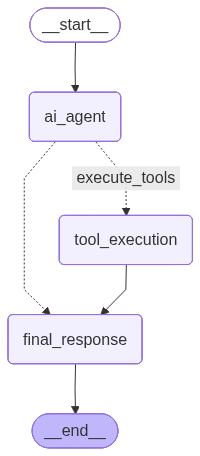

In [17]:
from IPython.display import Image, display

try:
    graph = rey_ai_assistant()
    
    display(
        Image(
            graph.get_graph().draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"그래프 표시 오류: {e}")

# 8단계 : 테스트

In [18]:
# LangGraph 완전 테스트 코드
def test_langgraph_complete():
    """완성된 LangGraph 시스템 전체 테스트"""
    
    print("🎉" * 20)
    print("🚀 LangGraph 완전 테스트 시작!")
    print("🎉" * 20)
    
    # 1단계: 그래프 생성 테스트
    print("\n📊 1단계: LangGraph 그래프 생성 테스트")
    try:
        graph = rey_ai_assistant()
        print("✅ LangGraph 그래프 생성 성공!")
    except Exception as e:
        print(f"❌ 그래프 생성 실패: {e}")
        return False
    
    # 2단계: 다양한 시나리오 테스트
    test_scenarios = [
        {
            "name": "RDB 검색 테스트",
            "query": "강서구에 있는 주택 알려줘",
            "expected_tool": "rdb_search",
            "description": "지역별 주택 정보 검색"
        },
        {
            "name": "벡터 검색 테스트", 
            "query": "청년 월세지원 제도에 대해 알려줘",
            "expected_tool": "vector_search",
            "description": "주거 지원 정책 정보 검색"
        },
        {
            "name": "복합 검색 테스트",
            "query": "송파구 주택 정보와 전세대출에 대해 알려줘",
            "expected_tool": "both",
            "description": "RDB + 벡터 검색 조합"
        },
        {
            "name": "일반 대화 테스트",
            "query": "안녕하세요! 내 이름은 홍길동이야. 나랑 대화하자",
            "expected_tool": "none",
            "description": "도구 없이 일반 대화"
        }
    ]
    
    results = []
    
    for i, scenario in enumerate(test_scenarios, 1):
        print(f"\n🧪 {i}단계: {scenario['name']}")
        print(f"   📝 쿼리: '{scenario['query']}'")
        print(f"   🎯 목적: {scenario['description']}")
        print("-" * 50)
        
        try:
            # LangGraph 실행
            from langchain_core.messages import HumanMessage
            
            initial_state = {
                "messages": [HumanMessage(content=scenario['query'])],
                "tools_used": []
            }
            
            # 그래프 실행
            print("🔄 그래프 실행 중...")
            final_state = graph.invoke(initial_state)
            
            # 결과 분석
            messages = final_state.get("messages", [])
            tools_used = final_state.get("tools_used", [])
            
            print(f"✅ 실행 완료!")
            print(f"📊 사용된 도구: {tools_used if tools_used else '없음'}")
            print(f"💬 메시지 수: {len(messages)}")
            
            # 최종 응답 출력
            if messages:
                final_message = messages[-1]
                if hasattr(final_message, 'content'):
                    response_preview = final_message.content[:200]
                    print(f"🤖 AI 응답 미리보기: {response_preview}...")
                else:
                    print(f"🤖 AI 응답: {str(final_message)[:200]}...")
            
            # 결과 저장
            results.append({
                "scenario": scenario['name'],
                "success": True,
                "tools_used": tools_used,
                "message_count": len(messages),
                "query": scenario['query']
            })
            
        except Exception as e:
            print(f"❌ 테스트 실패: {e}")
            results.append({
                "scenario": scenario['name'],
                "success": False,
                "error": str(e),
                "query": scenario['query']
            })
        
        print("\n" + "="*50)
    
    # 3단계: 결과 요약
    print("\n📋 테스트 결과 요약")
    print("=" * 60)
    
    success_count = sum(1 for r in results if r['success'])
    total_count = len(results)
    
    print(f"🎯 전체 테스트: {total_count}개")
    print(f"✅ 성공: {success_count}개")
    print(f"❌ 실패: {total_count - success_count}개")
    print(f"📊 성공률: {success_count/total_count*100:.1f}%")
    
    print("\n📝 상세 결과:")
    for result in results:
        status = "✅" if result['success'] else "❌"
        print(f"{status} {result['scenario']}")
        if result['success']:
            tools = result.get('tools_used', [])
            print(f"   🔧 도구: {', '.join(tools) if tools else '없음'}")
            print(f"   💬 메시지: {result.get('message_count', 0)}개")
        else:
            print(f"   ❌ 오류: {result.get('error', 'Unknown')}")
        print(f"   📝 쿼리: {result['query'][:50]}...")
        print()
    
    # 4단계: 성능 및 품질 평가
    print("\n⚡ 성능 및 품질 평가")
    print("-" * 30)
    
    # 도구 사용 분석
    all_tools_used = []
    for result in results:
        if result['success']:
            all_tools_used.extend(result.get('tools_used', []))
    
    if all_tools_used:
        from collections import Counter
        tool_counts = Counter(all_tools_used)
        print("🔧 도구 사용 통계:")
        for tool, count in tool_counts.items():
            print(f"   - {tool}: {count}회")
    else:
        print("🔧 도구 사용: 없음")
    
    # 전체 평가
    if success_count == total_count:
        print("\n🎉 모든 테스트 통과! LangGraph가 완벽하게 작동합니다!")
        grade = "A+"
    elif success_count >= total_count * 0.8:
        print("\n👍 대부분의 테스트 통과! 약간의 개선이 필요합니다.")
        grade = "B+"
    elif success_count >= total_count * 0.5:
        print("\n⚠️ 일부 테스트 실패. 추가 디버깅이 필요합니다.")
        grade = "C"
    else:
        print("\n🚨 많은 테스트 실패. 시스템 점검이 필요합니다.")
        grade = "D"
    
    print(f"📊 최종 등급: {grade}")
    
    return success_count == total_count

# 실행
test_langgraph_complete()

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
🚀 LangGraph 완전 테스트 시작!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

📊 1단계: LangGraph 그래프 생성 테스트
✅ LangGraph 그래프 생성 성공!

🧪 1단계: RDB 검색 테스트
   📝 쿼리: '강서구에 있는 주택 알려줘'
   🎯 목적: 지역별 주택 정보 검색
--------------------------------------------------
🔄 그래프 실행 중...
AI 에이전트가 요청을 분석 중...
1개의 도구를 사용합니다:
   - rdb_search: {'query': '강서구에 있는 주택 알려줘'}
라우팅: 도구 실행 필요 → 도구 실행 노드로
rdb_search 실행 중... (인자: {'query': '강서구에 있는 주택 알려줘'})


c:\dev\real-estate-for-the-young\.venv\Lib\site-packages\langchain_community\utilities\sql_database.py:134: SAWarning: Did not recognize type 'vector' of column 'embedding'
  self._metadata.reflect(
c:\dev\real-estate-for-the-young\.venv\Lib\site-packages\langchain_community\utilities\sql_database.py:134: SAWarning: Did not recognize type 'vector' of column 'query_embedding'
  self._metadata.reflect(
C:\Users\cywell\AppData\Local\Temp\ipykernel_8072\1210824091.py:17: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  query_tool = QuerySQLDataBaseTool(db=db)


rdb_search 실행 완료: [('cohouse_notice_af33ab0bab70', '코이노니아 스테이', '코이노니아 스테이', '서울 강서구 강서로47길 60 코이노니아스테이', '강서구', '내발산동...
최종 응답 생성 중...
✅ 실행 완료!
📊 사용된 도구: ['rdb_search']
💬 메시지 수: 4
🤖 AI 응답 미리보기: 강서구에 있는 주택에 대한 정보를 찾았습니다! 여기 두 가지 주택이 있습니다:

1. **코이노니아 스테이**
   - 주소: 서울 강서구 강서로47길 60
   - 지역: 내발산동
   - 특징: 다양한 커뮤니티 활동이 이루어지는 공간으로, 주택 외에도 다양한 서비스가 제공됩니다.

2. **삶을 잇는 공간 309 (7차제선주택)**
   - 주소: 서울...


🧪 2단계: 벡터 검색 테스트
   📝 쿼리: '청년 월세지원 제도에 대해 알려줘'
   🎯 목적: 주거 지원 정책 정보 검색
--------------------------------------------------
🔄 그래프 실행 중...
AI 에이전트가 요청을 분석 중...
1개의 도구를 사용합니다:
   - vector_search: {'query': '청년 월세지원 제도에 대해 알려줘'}
라우팅: 도구 실행 필요 → 도구 실행 노드로
vector_search 실행 중... (인자: {'query': '청년 월세지원 제도에 대해 알려줘'})
vector_search 실행 완료: ✅ 벡터 검색 결과 (2건):

1. [유사도: 0.883, ID: 1328]
   내용: &A Q17청년 월세 지원 신청과 관련하여 소식을 받고 싶은데 , 방법이 어떻게 될까요 ...
최종 응답 생성 중...
✅ 실행 완료!
📊 사용된 도구: ['vector_search']
💬 메시지 수: 4
🤖 AI 응답 미리보기: 청년 월세지원 제도는 서울시에서 운영하는 프로그램으로, 청년들이 보다 저렴하게 주거비를 지불할 수 있도록 돕는 제도입니다. 이 제도는 주로 19세에서 39세 

c:\dev\real-estate-for-the-young\.venv\Lib\site-packages\langchain_community\utilities\sql_database.py:134: SAWarning: Did not recognize type 'vector' of column 'embedding'
  self._metadata.reflect(
c:\dev\real-estate-for-the-young\.venv\Lib\site-packages\langchain_community\utilities\sql_database.py:134: SAWarning: Did not recognize type 'vector' of column 'query_embedding'
  self._metadata.reflect(


rdb_search 실행 완료: [('cohouse_notice_c49f953e0ac5', '셀렉티드 송파점', '서울특별시 송파구 중대로16길 24호', '송파구', '가락동', 'bt_04', datetime...
vector_search 실행 중... (인자: {'query': '송파구 전세대출 정보'})
vector_search 실행 완료: ✅ 벡터 검색 결과 (2건):

1. [유사도: 0.835, ID: 1102]
   내용: ※ 지원 대상자는 해당 자치구로 통보 예정입니다 . 신청서류는 무엇을 제출하면 되나요 ?...
최종 응답 생성 중...
✅ 실행 완료!
📊 사용된 도구: ['rdb_search', 'vector_search']
💬 메시지 수: 5
🤖 AI 응답 미리보기: 송파구의 주택 정보와 관련된 내용을 정리해 드릴게요!

### 송파구 주택 정보
송파구에는 다양한 주택 옵션이 존재합니다. 예를 들어, 최근에 올라온 주택 정보 중에는 다음과 같은 사례가 있습니다:

1. **위치**: 서울 송파구
   - **타입**: 아파트
   - **전세가**: 7,000만 원
   - **전용면적**: 17.0평
   - **세대...


🧪 4단계: 일반 대화 테스트
   📝 쿼리: '안녕하세요! 내 이름은 홍길동이야. 나랑 대화하자'
   🎯 목적: 도구 없이 일반 대화
--------------------------------------------------
🔄 그래프 실행 중...
AI 에이전트가 요청을 분석 중...
도구 사용 없이 직접 응답합니다.
라우팅: 도구 실행 불필요 → 최종 응답으로
최종 응답 생성 중...
✅ 실행 완료!
📊 사용된 도구: 없음
💬 메시지 수: 3
🤖 AI 응답 미리보기: 홍길동님, 안녕하세요! 반가워요. 어떤 이야기를 나누고 싶으신가요? 일상에 대한 이야기든, 궁금한 정보든 언제든지 이야기해 주세요! 😊...


📋 테스트 결과 요약
🎯 전체 테스트: 4개
✅ 성공: 4개
❌ 실패: 0개
📊 성공률: 100.0

True